In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import mnist_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F


# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


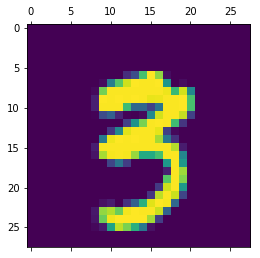

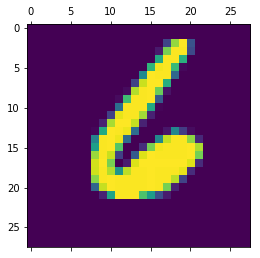

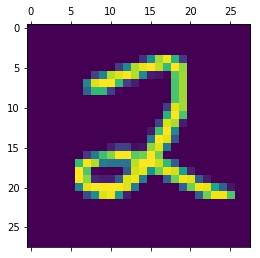

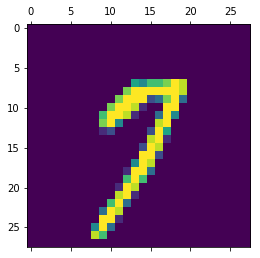

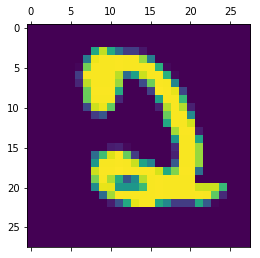

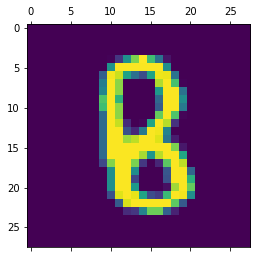

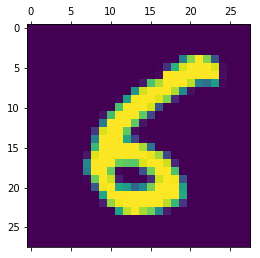

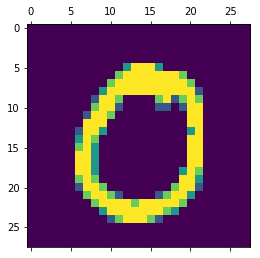

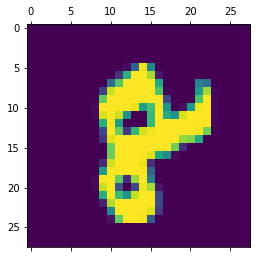

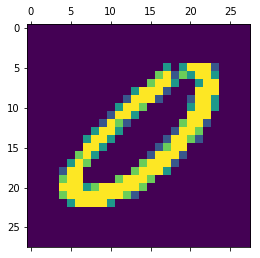

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

In [5]:
slen = train_set_labeled[0]['image'].shape[0]

# Get data loaders

In [6]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [7]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [8]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

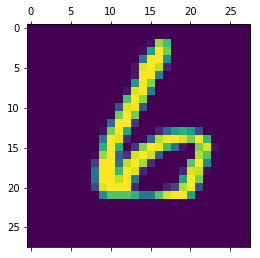

In [9]:
plt.matshow(data_unlabeled['image'][0, :, :])

# Define VAE

In [10]:
latent_dim = 6
n_classes = 10

In [11]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [12]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=12, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=10, bias=True)
    (log_softmax): LogSoftmax()
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [13]:
28 * 28

784

In [14]:
### Check things run

In [15]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

In [16]:
# check dimensions of encoder output

log_class_weights = vae.classifier(data_unlabeled['image'])
assert log_class_weights.shape[0] == batchsize
assert log_class_weights.shape[1] == n_classes 

latent_means, latent_std = \
    vae.encoder(data_unlabeled['image'], log_class_weights)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim


In [17]:
cat_rv = torch.distributions.Categorical(probs = torch.exp(log_class_weights))
z_ind = cat_rv.sample()

In [18]:
z_ind

tensor([ 9,  2,  7,  8,  0,  4,  0,  6,  3,  1,  4,  9])

In [19]:
# check one hot encoding 

one_hot_z = mnist_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

for n in range(batchsize): 
    foo = one_hot_z[n, :]
    
    assert foo[z_ind[n]] == 1.
    assert sum(foo) == 1.

In [20]:
# check decoder output size 
image_mean = vae.decoder(latent_means, one_hot_z)
assert image_mean.shape[0] == batchsize
assert image_mean.shape[1] == slen
assert image_mean.shape[1] == slen

In [21]:
# check loss goes through

In [22]:
vae.get_conditional_loss(data_labeled['image'], data_labeled['label'])

tensor([ 543.5626,  544.0776,  543.7934,  543.8060,  543.4217,  543.9177])

In [23]:
vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'],
                            use_baseline = True,
                            alpha = 1.0, topk = 0)

tensor(6524.2051)


(tensor(9826.8418), tensor(6521.6396))

# Check gradient works 

In [24]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [25]:
vae_params0 = get_vae_params(vae)

In [26]:
assert np.any(np.isnan(vae_params0)) == False

In [27]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [28]:
loss, map_loss1 = vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'],
                            use_baseline = True,
                            alpha = 1.0, topk = 0)
print(map_loss1)

tensor(6521.0415)
tensor(6521.6226)


In [29]:
loss.backward()
optimizer.step()

In [30]:
vae_params1 = get_vae_params(vae)

In [31]:
assert np.any(np.isnan(vae_params1)) == False

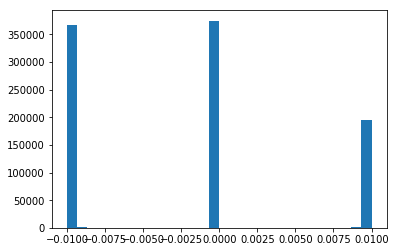

In [32]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [33]:
loss, map_loss2 = vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'],
                            use_baseline = True,
                            alpha = 1.0, topk = 0)


tensor(5210.7100)


In [34]:
map_loss2

tensor(4672.1001)

In [35]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [36]:
from torch.utils.data.sampler import Sampler

In [37]:
mnist_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test')

tensor(-5962.8359)
tensor(-6745.9902)
tensor(-5025.6885)
tensor(-5267.9111)
tensor(-3377.3530)
tensor(-4716.2041)
  * init train recon loss: 387.7614136;
  * init test recon loss: 373.0303345;
  * init train class accuracy: 0.1667;
  * init test class accuracy:    0;
tensor(4638.6992)
tensor(4209.0137)
tensor(3280.6648)
tensor(4149.7158)
tensor(1156.9817)
[1] unlabeled_loss: 317.9014282  	[0.1 seconds]
tensor(3352.7629)
tensor(2956.2971)
tensor(2158.6787)
tensor(2360.8621)
tensor(1091.9042)
[2] unlabeled_loss: 200.9206848  	[0.1 seconds]
tensor(-2780.9937)
tensor(-2724.7896)
tensor(-2585.3765)
tensor(-2872.8086)
tensor(-1638.0559)
tensor(-2727.2720)
  * train recon loss: 175.3902283;
  * test recon loss: 166.9484558;
  * train class accuracy: 0.05556;
  * test class accuracy:  0.1;
tensor(2298.0071)
tensor(2335.2437)
tensor(1897.7003)
tensor(1913.8828)
tensor(1043.6851)
[3] unlabeled_loss: 163.9262238  	[0.1 seconds]
tensor(2337.6709)
tensor(1931.3740)
tensor(1609.5356)
tensor(1700.387

In [38]:
torch.exp(vae.classifier(data_unlabeled['image']).detach())

tensor([[ 0.1219,  0.0656,  0.0925,  0.1496,  0.0859,  0.1041,  0.1048,
          0.1041,  0.0652,  0.1063],
        [ 0.1138,  0.0691,  0.0961,  0.1412,  0.0874,  0.1040,  0.1071,
          0.1016,  0.0709,  0.1089],
        [ 0.1247,  0.0621,  0.0927,  0.1567,  0.0837,  0.1012,  0.1082,
          0.1041,  0.0617,  0.1049],
        [ 0.1178,  0.0680,  0.0994,  0.1450,  0.0844,  0.1033,  0.1030,
          0.1023,  0.0680,  0.1089],
        [ 0.1154,  0.0739,  0.0965,  0.1330,  0.0880,  0.1033,  0.1041,
          0.1007,  0.0768,  0.1084],
        [ 0.1285,  0.0629,  0.0956,  0.1536,  0.0852,  0.1031,  0.1056,
          0.1036,  0.0642,  0.0977],
        [ 0.1230,  0.0618,  0.0940,  0.1592,  0.0837,  0.1039,  0.1055,
          0.1058,  0.0593,  0.1038],
        [ 0.1230,  0.0616,  0.0957,  0.1578,  0.0831,  0.1043,  0.1069,
          0.1062,  0.0593,  0.1021],
        [ 0.1289,  0.0591,  0.0948,  0.1650,  0.0814,  0.1036,  0.1033,
          0.1059,  0.0559,  0.1021],
        [ 0.1218,  

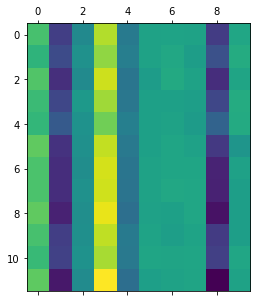

In [39]:
plt.matshow(vae.classifier(data_unlabeled['image']).detach())

In [40]:
# check reloading

In [41]:
reload_vae = vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [39]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'

reload_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


In [42]:
reload_vae.eval_vae(train_loader_unlabeled, data_labeled['image'], 
                                        data_labeled['label'])

tensor(143.5399)

In [52]:
recon_mean, _ =  mnist_vae_lib.get_reconstructions(vae, data_unlabeled['image'])

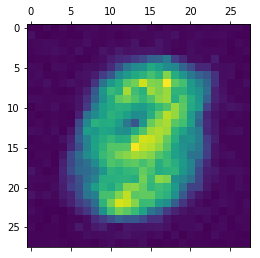

In [55]:
plt.matshow(recon_mean[3, :, :].detach())